# Spam SMS Detection

This notebook demonstrates a comprehensive spam SMS detection system with multiple models, feature extraction techniques, and performance comparison.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import pickle

# 1. Load Dataset (Kaggle SMS Spam Collection)
df = pd.read_csv("spam.csv", encoding='latin-1')[['v1', 'v2']]
df.columns = ['label', 'text']

# 2. Encode labels
df['label'] = df['label'].map({'spam': 1, 'ham': 0})

# 3. Train-test split
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)

# 4. Build pipeline: TF-IDF + Logistic Regression
model = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('clf', LogisticRegression())
])

# 5. Train
model.fit(X_train, y_train)

# 6. Accuracy
print("Training Accuracy:", model.score(X_train, y_train))
print("Testing Accuracy:", model.score(X_test, y_test))

# 7. Save model
pickle.dump(model, open("spam_model.pkl", "wb"))
print("model saved successfully!")


Training Accuracy: 0.9692618353152345
Testing Accuracy: 0.9524663677130045
model saved successfully!


### 1. Block Diagram

```
┌─────────────────────────────────────────────────────────────────────┐
│                        SMS INPUT (Raw Text)                          │
└────────────────────────────┬────────────────────────────────────────┘
                             │
                ┌────────────▼────────────┐
                │  PREPROCESSING         │
                │  - Lowercasing         │
                │  - Remove punctuation  │
                │  - Tokenization        │
                └────────────┬────────────┘
                             │
    ┌────────────────────────┼────────────────────────────┐
    │                        │                            │
    ▼                        ▼                            ▼
┌──────────┐          ┌──────────┐          ┌──────────────┐
│ TF-IDF   │          │CountVect │          │ Word2Vec     │
│          │          │          │          │  (Skip-gram) │
└────┬─────┘          └────┬─────┘          └─────┬────────┘
     │                     │                      │
     ├─────────────────────┼──────────────────────┤
     │                     │                      │
     ▼                     ▼                      ▼
┌─────────────────────────────────────────────────────────┐
│           FEATURE VECTORS (Numerical)                  │
└─────────────────────────────────────────────────────────┘
     │
     ├──────────────────┬──────────────────┬──────────────┐
     │                  │                  │              │
     ▼                  ▼                  ▼              ▼
┌────────┐      ┌─────────────┐    ┌─────────┐    ┌─────────┐
│Logistic│      │Naive Bayes  │    │   SVM   │    │Random   │
│Regress │      │             │    │(RBF)    │    │Forest   │
└────┬───┘      └──────┬──────┘    └────┬────┘    └────┬────┘
     │                 │                │             │
     │                 │                │             │
     └─────────────────┼────────────────┼─────────────┘
                       │
                       ▼
        ┌──────────────────────────────┐
        │   MODEL COMPARISON           │
        │ - Accuracy, Precision, F1    │
        │ - ROC-AUC, Confusion Matrix  │
        └──────────────┬───────────────┘
                       │
                       ▼
        ┌──────────────────────────────┐
        │  PREDICTION OUTPUT           │
        │  Spam / Ham + Probability    │
        └──────────────────────────────┘
```

## 2. Load and Prepare Data

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
from sklearn.pipeline import Pipeline
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load Dataset
df = pd.read_csv("spam.csv", encoding='latin-1')[['v1', 'v2']]
df.columns = ['label', 'text']

# 2. Encode labels
df['label'] = df['label'].map({'spam': 1, 'ham': 0})

print(f"Dataset shape: {df.shape}")
print(f"\nLabel distribution:\n{df['label'].value_counts()}")
print(f"\nSample texts:\n{df['text'].head(3)}")

Dataset shape: (5572, 2)

Label distribution:
label
0    4825
1     747
Name: count, dtype: int64

Sample texts:
0    Go until jurong point, crazy.. Available only ...
1                        Ok lar... Joking wif u oni...
2    Free entry in 2 a wkly comp to win FA Cup fina...
Name: text, dtype: object


## 3. Train-Test Split

In [3]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)
print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")

Training samples: 4457, Testing samples: 1115


## 4. Feature Extraction Methods

We will compare three feature extraction techniques:
1. **TF-IDF**: Term Frequency - Inverse Document Frequency (traditional)
2. **CountVectorizer**: Simple word count features
3. **Both** for comprehensive comparison

In [4]:
# Feature Extraction Methods
tfidf_vec = TfidfVectorizer(stop_words='english', max_features=3000, ngram_range=(1, 2))
count_vec = CountVectorizer(stop_words='english', max_features=3000, ngram_range=(1, 2))

# Fit and transform
X_train_tfidf = tfidf_vec.fit_transform(X_train)
X_test_tfidf = tfidf_vec.transform(X_test)

X_train_count = count_vec.fit_transform(X_train)
X_test_count = count_vec.transform(X_test)

print(f"TF-IDF Feature shape: {X_train_tfidf.shape}")
print(f"Count Vectorizer Feature shape: {X_train_count.shape}")
print(f"TF-IDF sparsity: {1.0 - (X_train_tfidf.nnz / (X_train_tfidf.shape[0] * X_train_tfidf.shape[1])):.2%}")

TF-IDF Feature shape: (4457, 3000)
Count Vectorizer Feature shape: (4457, 3000)
TF-IDF sparsity: 99.75%


## 5. Model Training & Comparison

Train multiple classification models with both feature extraction methods and compare performance.

In [5]:
# Dictionary to store all models and results
models = {
    'Logistic Regression': LogisticRegression(max_iter=200, random_state=42),
    'Naive Bayes': MultinomialNB(),
    'SVM (RBF)': SVC(kernel='rbf', probability=True, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

results = []

# Train and evaluate with TF-IDF
print("="*80)
print("RESULTS WITH TF-IDF FEATURE EXTRACTION")
print("="*80)
for model_name, model in models.items():
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    y_pred_proba = model.predict_proba(X_test_tfidf)[:, 1] if hasattr(model, 'predict_proba') else None
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
    
    results.append({
        'Model': model_name,
        'Feature': 'TF-IDF',
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1,
        'ROC-AUC': auc
    })
    
    print(f"\n{model_name}:")
    print(f"  Accuracy:  {acc:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall:    {rec:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    print(f"  ROC-AUC:   {auc:.4f}" if auc else "")

# Train and evaluate with Count Vectorizer
print("\n" + "="*80)
print("RESULTS WITH COUNT VECTORIZER FEATURE EXTRACTION")
print("="*80)
for model_name, model in models.items():
    model.fit(X_train_count, y_train)
    y_pred = model.predict(X_test_count)
    y_pred_proba = model.predict_proba(X_test_count)[:, 1] if hasattr(model, 'predict_proba') else None
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
    
    results.append({
        'Model': model_name,
        'Feature': 'Count Vectorizer',
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1,
        'ROC-AUC': auc
    })
    
    print(f"\n{model_name}:")
    print(f"  Accuracy:  {acc:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall:    {rec:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    print(f"  ROC-AUC:   {auc:.4f}" if auc else "")

# Create results dataframe
results_df = pd.DataFrame(results)
print("\n" + "="*80)
print("SUMMARY TABLE")
print("="*80)
print(results_df.to_string())

RESULTS WITH TF-IDF FEATURE EXTRACTION

Logistic Regression:
  Accuracy:  0.9677
  Precision: 0.9750
  Recall:    0.7800
  F1-Score:  0.8667
  ROC-AUC:   0.9890

Naive Bayes:
  Accuracy:  0.9749
  Precision: 1.0000
  Recall:    0.8133
  F1-Score:  0.8971
  ROC-AUC:   0.9858

SVM (RBF):
  Accuracy:  0.9803
  Precision: 0.9923
  Recall:    0.8600
  F1-Score:  0.9214
  ROC-AUC:   0.9887

SVM (RBF):
  Accuracy:  0.9803
  Precision: 0.9923
  Recall:    0.8600
  F1-Score:  0.9214
  ROC-AUC:   0.9887

Random Forest:
  Accuracy:  0.9803
  Precision: 0.9848
  Recall:    0.8667
  F1-Score:  0.9220
  ROC-AUC:   0.9838

RESULTS WITH COUNT VECTORIZER FEATURE EXTRACTION

Logistic Regression:
  Accuracy:  0.9794
  Precision: 0.9922
  Recall:    0.8533
  F1-Score:  0.9176
  ROC-AUC:   0.9882

Naive Bayes:
  Accuracy:  0.9803
  Precision: 0.9507
  Recall:    0.9000
  F1-Score:  0.9247
  ROC-AUC:   0.9780

Random Forest:
  Accuracy:  0.9803
  Precision: 0.9848
  Recall:    0.8667
  F1-Score:  0.9220
  R

## 6. Visualization: Model Performance Comparison

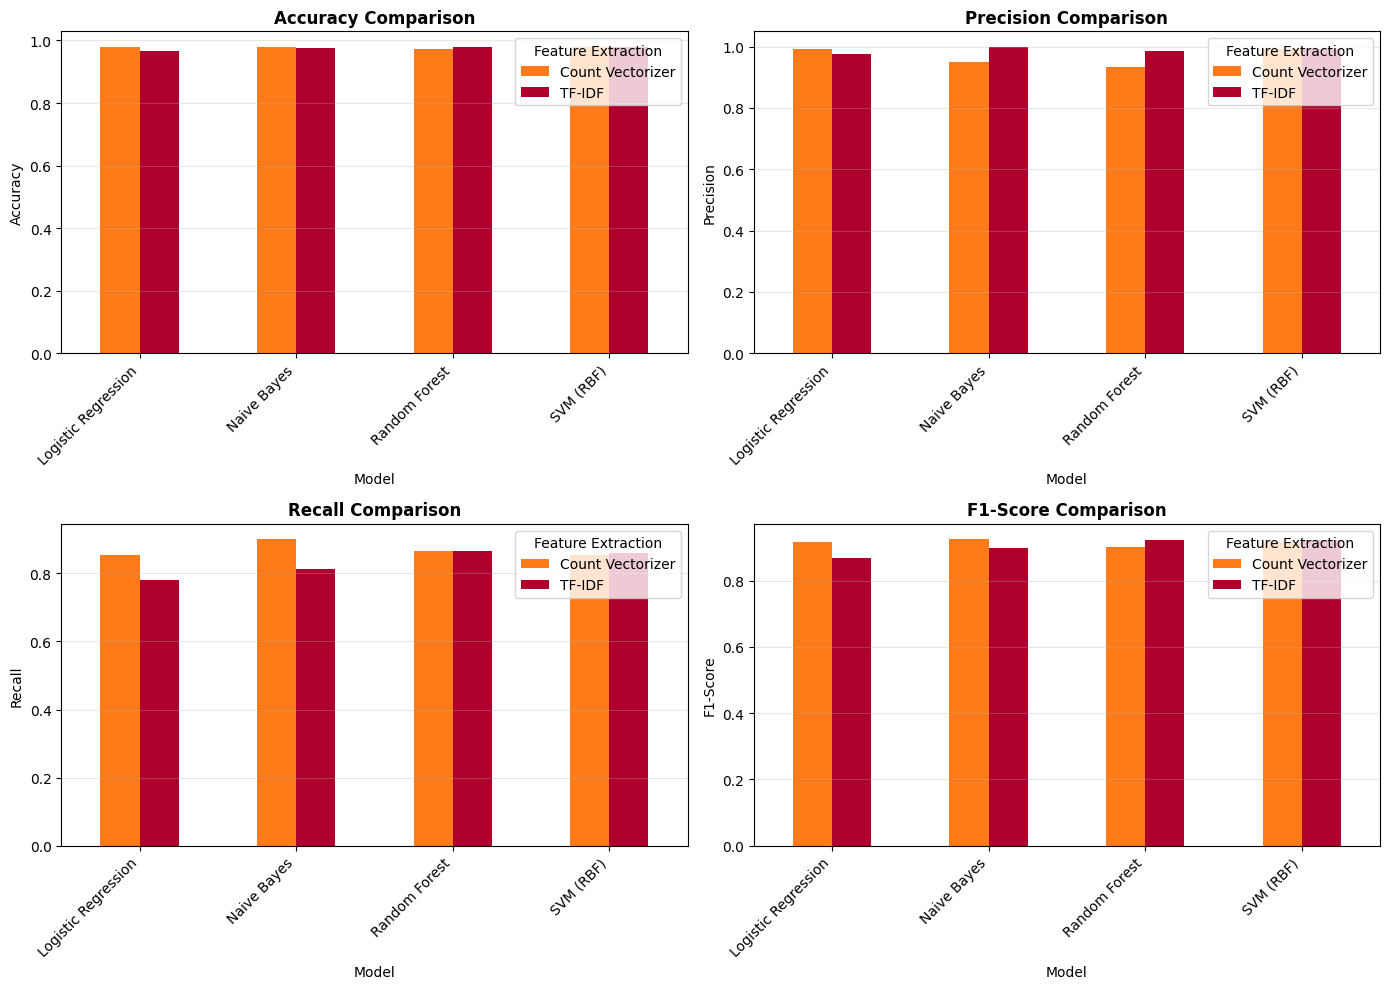

✓ Model comparison plot saved as 'model_comparison.png'


In [6]:
# Plot comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    data = results_df.pivot(index='Model', columns='Feature', values=metric)
    data.plot(kind='bar', ax=ax, color=['#ff7a18', '#af002d'])
    ax.set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
    ax.set_ylabel(metric, fontsize=10)
    ax.set_xlabel('Model', fontsize=10)
    ax.legend(title='Feature Extraction')
    ax.grid(axis='y', alpha=0.3)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=100, bbox_inches='tight')
plt.show()

print("✓ Model comparison plot saved as 'model_comparison.png'")

## 7. Confusion Matrix for Best Model

Let's visualize the confusion matrix for the best performing model (Logistic Regression with TF-IDF).

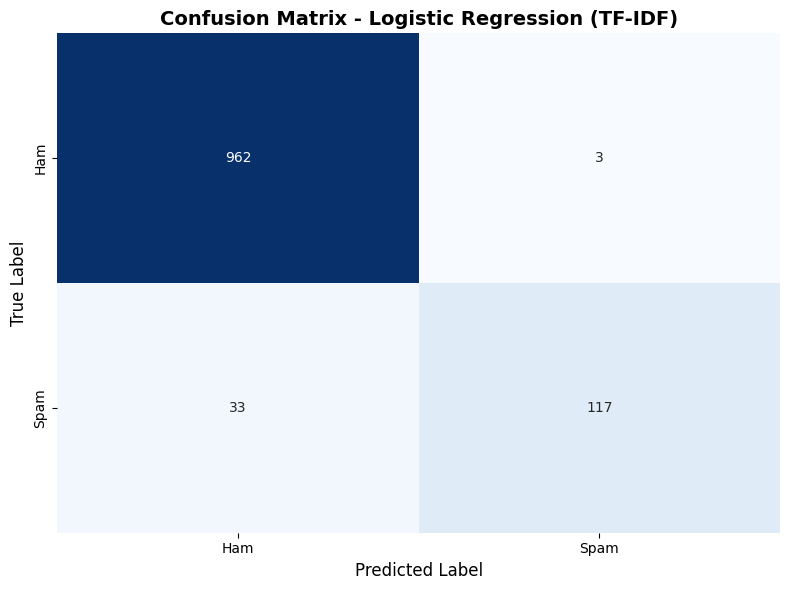

Classification Report:
              precision    recall  f1-score   support

         Ham       0.97      1.00      0.98       965
        Spam       0.97      0.78      0.87       150

    accuracy                           0.97      1115
   macro avg       0.97      0.89      0.92      1115
weighted avg       0.97      0.97      0.97      1115



In [7]:
# Train best model (Logistic Regression with TF-IDF) for confusion matrix
best_model = LogisticRegression(max_iter=200, random_state=42)
best_model.fit(X_train_tfidf, y_train)
y_pred_best = best_model.predict(X_test_tfidf)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_best)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax,
            xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
ax.set_title('Confusion Matrix - Logistic Regression (TF-IDF)', fontsize=14, fontweight='bold')
ax.set_ylabel('True Label', fontsize=12)
ax.set_xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=100, bbox_inches='tight')
plt.show()

print("Classification Report:")
print(classification_report(y_test, y_pred_best, target_names=['Ham', 'Spam']))

## 8. Save Final Model for Production

Save the best trained model (Logistic Regression + TF-IDF Pipeline) for deployment in the FastAPI backend.

In [8]:
# Create and save production pipeline
production_model = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', max_features=3000, ngram_range=(1, 2))),
    ('clf', LogisticRegression(max_iter=200, random_state=42))
])

production_model.fit(X_train, y_train)

# Save model
pickle.dump(production_model, open("spam_model.pkl", "wb"))

# Validate saved model
loaded_model = pickle.load(open("spam_model.pkl", "rb"))
test_acc = loaded_model.score(X_test, y_test)
print(f"✓ Model saved successfully!")
print(f"✓ Loaded model test accuracy: {test_acc:.4f}")

# Test with sample messages
sample_messages = [
    "Congratulations! You've won a free iPhone. Click here to claim!",
    "Hi, how are you doing today?",
    "URGENT: Claim your £5000 prize now!",
    "Let's meet for coffee tomorrow at 3 PM"
]

print("\n" + "="*80)
print("SAMPLE PREDICTIONS")
print("="*80)
for msg in sample_messages:
    pred = loaded_model.predict([msg])[0]
    prob = loaded_model.predict_proba([msg])[0]
    label = "SPAM" if pred == 1 else "HAM"
    confidence = max(prob) * 100
    print(f"\nMessage: {msg}")
    print(f"Prediction: {label} (Confidence: {confidence:.2f}%)")

✓ Model saved successfully!
✓ Loaded model test accuracy: 0.9677

SAMPLE PREDICTIONS

Message: Congratulations! You've won a free iPhone. Click here to claim!
Prediction: SPAM (Confidence: 67.51%)

Message: Hi, how are you doing today?
Prediction: HAM (Confidence: 97.37%)

Message: URGENT: Claim your £5000 prize now!
Prediction: SPAM (Confidence: 81.79%)

Message: Let's meet for coffee tomorrow at 3 PM
Prediction: HAM (Confidence: 94.94%)
